# Environment set up

In this section we will set up a Colab environment for the MLEnd mini-project.

In [2]:
from google.colab import drive

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os, sys, re, pickle, glob
import urllib.request
import zipfile

#from IPython.display import Audio
import IPython.display as ipd
from tqdm import tqdm
import librosa
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

Running the below cell checks the MLEnd folder which contains all our data including our trainingMLEnd.csv

In [4]:
path = '/content/drive/MyDrive/Data/MLEnd'
os.listdir(path)

['trainingMLEnd.csv', 'training', 'training.zip']

# Data download

In this section we will download the data that we will need to build our solutions. 
First, we will define a function that will allow us to download a file into a chosen location.

In [ ]:
def download_url(url, save_path):
    with urllib.request.urlopen(url) as dl_file:
        with open(save_path, 'wb') as out_file:
            out_file.write(dl_file.read())

The next step is to download the file 'training.zip' into the folder 'MyDrive/Data/MLEnd'.

In [ ]:
url  = "https://collect.qmul.ac.uk/down?t=6H8231DQL1NGDI9A/613DLM2R3OFV5EEH9INK2OG"
save_path = '/content/drive/MyDrive/Data/MLEnd/training.zip'
download_url(url, save_path)

Here we will unzip the training file.

In [ ]:
directory_to_extract_to = '/content/drive/MyDrive/Data/MLEnd/training/'
with zipfile.ZipFile(save_path, 'r') as zip_ref:
    zip_ref.extractall(directory_to_extract_to)

Once the extraction of the zip file is done we can see how many audio files we have in our training dataset.

In [5]:
files = glob.glob('/content/drive/MyDrive/Data/MLEnd/training/*/*.wav')
len(files)

20000

The above figure (20k) is the number of items or samples in our dataset.

We can listen to some random audio files and can try to identify the numeral or the intonation.

In [6]:
# five random files
for _ in range(5):
  n = np.random.randint(20000)
  display(ipd.Audio(files[n]))

Now we will load the contents of 'trainingMLEnd.csv' into a pandas DataFrame and we can explore them

In [7]:
labels = pd.read_csv('/content/drive/MyDrive/Data/MLEnd/trainingMLEnd.csv')
labels

,File ID,digit_label,participant,intonation
0,0000000.wav,4,S73,question
1,0000001.wav,2,S88,excited
2,0000002.wav,70,S5,neutral
3,0000003.wav,2,S85,bored
4,0000004.wav,4,S30,excited
...,...,...,...,...
19995,0019995.wav,90,S163,excited
19996,0019996.wav,10,S99,question
19997,0019997.wav,90,S46,question
19998,0019998.wav,19,S13,neutral


Here I am importing Seaborn to visualise the data with some plots.

In [8]:
import seaborn as sns

In [9]:
intonat = pd.DataFrame(labels['intonation'])

Here I have converted the intonation columns into the dataframe using pandas library to visualise it.

In [10]:
intonat

,intonation
0,question
1,excited
2,neutral
3,bored
4,excited
...,...
19995,excited
19996,question
19997,question
19998,neutral


Here I have plotted a histogram which has different intonations on the x-axis and count on the y-axis. We can see that there are total 500 intonations of each intonation class (question, excited, neutral, bored).

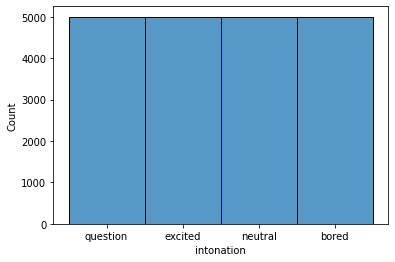

In [11]:
sns.histplot(labels['intonation'])

Again I have plotted a countplot of the intonations which again confirm a total 5000 for each intonation which are question, excited, neutral, bored.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


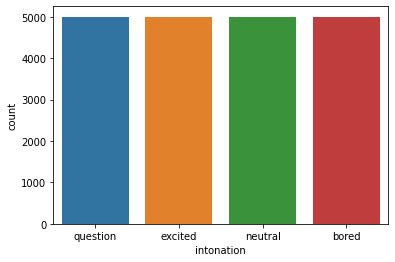

In [13]:
sns.countplot(labels['intonation'])

Here again I have used a countplot to plot the digit_label column wher we can see differnet counts for every integer.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


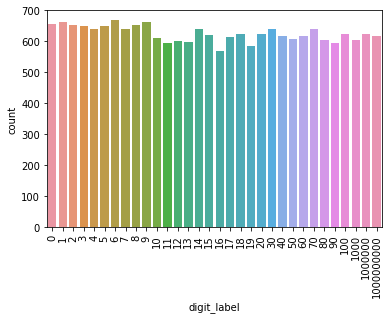

In [23]:
sns.countplot(labels['digit_label'])
plt.xticks(rotation="90")
plt.show()

Audio files are complex data types. Specifically they are **discrete signals** or **time series**, consisting of values on a 1D grid. These values are known as *samples* themselves, which might be a bit confusing, as we have used this term to refer to the *items* in our dataset. The **sampling frequency** is the rate at which samples in an audio file are produced. For instance a sampling frequency of 5HZ indicates that 5 produce 5 samples per second, or 1 sample every 0.2 s.

Let's plot one of our audio signals:

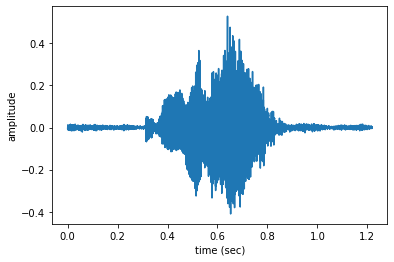

In [24]:
n=0
fs = None # Sampling frequency. If None, fs would be 22050
x, fs = librosa.load(files[n],sr=fs)
t = np.arange(len(x))/fs
plt.plot(t,x)
plt.xlabel('time (sec)')
plt.ylabel('amplitude')
plt.show()
display(ipd.Audio(files[n]))

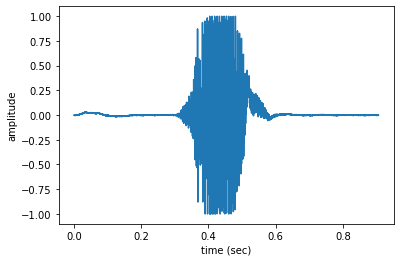

In [25]:
n=1
fs = None # Sampling frequency. If None, fs would be 22050
x, fs = librosa.load(files[n],sr=fs)
t = np.arange(len(x))/fs
plt.plot(t,x)
plt.xlabel('time (sec)')
plt.ylabel('amplitude')
plt.show()
display(ipd.Audio(files[n]))

We can see here which file we are listening.

In [26]:
files[n]

'/content/drive/MyDrive/Data/MLEnd/training/Training/0018596.wav'

In [27]:
n=0
x, fs = librosa.load(files[n],sr=fs)
print('This audio signal has', len(x), 'samples')

This audio signal has 26880 samples


Now we will try to extract few features from our signals and use these features instead as our predictors. In the following cell we will define a funciton that extracts four features of an audio signal which are :
1. Power
2. Pitch mean
3. Pitch standard deviation
4. Fraction of voiced region

In the below block of cell we define a function that gets pitch of an audio signal.

In [28]:
def getPitch(x,fs,winLen=0.02):
  #winLen = 0.02 
  p = winLen*fs
  frame_length = int(2**int(p-1).bit_length())
  hop_length = frame_length//2
  f0, voiced_flag, voiced_probs = librosa.pyin(y=x, fmin=80, fmax=450, sr=fs,
                                                 frame_length=frame_length,hop_length=hop_length)
  return f0,voiced_flag

**BASIC SOLUTION**

For baisc solution I am building a model that will predict the intoanation of a short audio segment.

The next cell defines a function that takes a number of files and creates a NumPy array containing the 4 audio features used as predictors (`X`) and their labels (`y`). 

In [29]:
def getXy(files,labels_file,scale_audio=False, onlySingleDigit=False):
  X,y =[],[]
  for file in tqdm(files):
    fileID = file.split('/')[-1]
    yi = list(labels_file[labels_file['File ID']==fileID]['intonation'])[0]
    if onlySingleDigit and yi>9:
      continue
    else:
      fs = None # if None, fs would be 22050
      x, fs = librosa.load(file,sr=fs)
      if scale_audio: x = x/np.max(np.abs(x))
      f0, voiced_flag = getPitch(x,fs,winLen=0.02)
      
      power = np.sum(x**2)/len(x)
      pitch_mean = np.nanmean(f0) if np.mean(np.isnan(f0))<1 else 0
      pitch_std  = np.nanstd(f0) if np.mean(np.isnan(f0))<1 else 0
      voiced_fr = np.mean(voiced_flag)
      xi = [power,pitch_mean, pitch_std,voiced_fr]
      X.append(xi)
      y.append(yi)
  return np.array(X),np.array(y)

Let's apply 'getXy' to the first 2000 files. We are using all the digits, so we have kept the onlySingleDigit = False. 

In [30]:
X,y = getXy(files[:2000],labels_file=labels,scale_audio=True, onlySingleDigit=False)

# If you want to use all 20000 files, run next line instead
#X,y = getXy(files,labels_file=labels,scale_audio=True, onlySingleDigit=True)

100%|██████████| 2000/2000 [14:03<00:00,  2.37it/s]


The next cell shows the shape of `X` and `y` and prints the labels vector `y`:

In [31]:
print('The shape of X is', X.shape) 
print('The shape of y is', y.shape)
print('The labels vector is', y)

The shape of X is (2000, 4)
The shape of y is (2000,)
The labels vector is ['bored' 'question' 'excited' ... 'excited' 'excited' 'question']


Finally we wil check if there is any NAN (not a number) file and eliminate if we find one.

In [32]:
# If nan sample, remove them
if np.sum(np.isnan(X)):
  idx = np.isnan(X).sum(1)>0
  X = X[~idx]
  y = y[~idx]
print(np.sum(np.isnan(X)))

0


# Modeling:
Support Vector Machines


Now we will split our dataset into train and validation and will start by applying the support vector machine.

In [33]:
from sklearn import svm
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X,y,test_size=0.3)
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((1400, 4), (600, 4), (1400,), (600,))

Here we can see that we have applied the train test split from sklear an applied on our data.

Now we are using GridSearchCV from sklearn library which will help us to tune the hyperparameters which will give us the best accuracy and best parameters for our model on our data.

In [34]:
from sklearn.model_selection import GridSearchCV

Now we will start by using the SVM model.

**SVM**

Here we are tuning out hyperparameters for our SVM model.
We are tuning the parameters as follows:


C: Regularisation Parameter.
gamma: Kernel coefficient for ‘rbf’, ‘poly’ and ‘sigmoid’.
kernel: It specifies the kernel type to be used in the algorithm.
class_weight: We select the class_weight as dict or balanced and default value is None.

In [35]:
parameters = {
    
    'C': [ 2,2.5, 3],
    'gamma': [ 0.2, 0.3,0.1, 0.01,0.001,0.02, 'scale'],
    'kernel': ['rbf', 'linear', 'sigmoid'],
    'class_weight': ['balanced']

}
grid_model = svm.SVC()
grid_svc = GridSearchCV(grid_model, parameters, n_jobs=-1)

grid_svc.fit(X_train,y_train)

#yt_p = grid_svc.predict(X_train)
#yv_p = grid_svc.predict(X_val)

#print('Training Accuracy', np.mean(yt_p==y_train))
#print('Validation  Accuracy', np.mean(yv_p==y_val))

GridSearchCV(cv=None, error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=-1,
             param_grid={'C': [2, 2.5, 3], 'class_weight': ['balanced'],
                         'gamma': [0.2, 0.3, 0.1, 0.01, 0.001, 0.02, 'scale'],
                         'kernel': ['rbf', 'linear', 'sigmoid']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In the below cell we are calling the grid method and finding what best score was possible for the model with the above parameters.

In [36]:
grid_svc.best_score_

0.4878571428571429

grid_svc.best_params gives us the best parameters for our model with the given parameters, which we can use in our model to give us the best accuracy.

In [37]:
grid_svc.best_params_

{'C': 3, 'class_weight': 'balanced', 'gamma': 0.001, 'kernel': 'rbf'}

Here we are using the above parameters in our svm model in the below cell.

In [38]:
model  = svm.SVC(C=3, gamma=0.001, kernel='rbf', class_weight='balanced')
model.fit(X_train,y_train)

yt_p = model.predict(X_train)
yv_p = model.predict(X_val)

print('Training Accuracy', np.mean(yt_p==y_train))
print('Validation  Accuracy', np.mean(yv_p==y_val))

Training Accuracy 0.5321428571428571
Validation  Accuracy 0.5083333333333333


We can see in the above output we are getting 50.8% percent accuracy for our validation data and 53.2% for our training accuracy.

In the below cell of code I am plotting the confusion matrix. and in the next cell using seaborn to plot the confusion matrix.

In [40]:
x = metrics.confusion_matrix(y_val, yv_p, labels=['bored', 'excited', 'neutral', 'question'])
y = metrics.confusion_matrix(y_train, yt_p, labels=['bored', 'excited', 'neutral', 'question'])
tones = ['bored', 'excited', 'neutral', 'question']

Valdiaiton confusion matrix

Text(91.68, 0.5, 'predicted label')

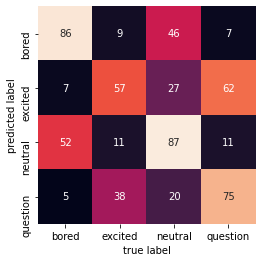

In [41]:
sns.heatmap(x,square=True, annot=True, fmt='d', cbar=False,
            xticklabels = tones,
            yticklabels = tones)
plt.xlabel('true label')
plt.ylabel('predicted label')

Training Confusion Matrix

Text(91.68, 0.5, 'predicted label')

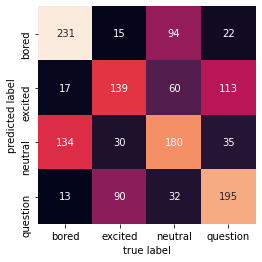

In [42]:
sns.heatmap(y,square=True, annot=True, fmt='d', cbar=False,
            xticklabels = tones,
            yticklabels = tones)
plt.xlabel('true label')
plt.ylabel('predicted label')

In the below two cell of code I am plotting the classification report of our model, which gives detail overview of teh precision, recall, f1-score and support for all the intonations and also accuracy, macro avg and weighted avg.

In [43]:
print(classification_report(y_val, yv_p))

              precision    recall  f1-score   support

       bored       0.57      0.58      0.58       148
     excited       0.50      0.37      0.43       153
     neutral       0.48      0.54      0.51       161
    question       0.48      0.54      0.51       138

    accuracy                           0.51       600
   macro avg       0.51      0.51      0.51       600
weighted avg       0.51      0.51      0.51       600



In [44]:
print(classification_report(y_train, yt_p))

              precision    recall  f1-score   support

       bored       0.58      0.64      0.61       362
     excited       0.51      0.42      0.46       329
     neutral       0.49      0.47      0.48       379
    question       0.53      0.59      0.56       330

    accuracy                           0.53      1400
   macro avg       0.53      0.53      0.53      1400
weighted avg       0.53      0.53      0.53      1400



In the below cell i am normalising the predictors to check if we are getting higher accuracy.

**SVM on Normalised Data**

In [45]:
mean = X_train.mean(0)
sd =  X_train.std(0)

X_train_normalised = (X_train-mean)/sd
X_val_normalised  = (X_val-mean)/sd

Here again I am using Grid Search Cv to tune our hyperparameters and get the best accuracy and best scores for our model with normalised predictors.

In [51]:
parameters = {
    
    'C': [2,8,9,10,11],
    'gamma': [0.01, 0.001,0.2, 0.1, 'scale'],
    'kernel': ['rbf', 'linear'],
    'class_weight': ['balanced']
}
grid_model = svm.SVC()
grid_svc1 = GridSearchCV(grid_model, parameters, n_jobs=-1)

grid_svc1.fit(X_train_normalised,y_train)

yt_p1 = grid_svc1.predict(X_train_normalised)
yv_p1 = grid_svc1.predict(X_val_normalised)

print('Training Accuracy', np.mean(yt_p1==y_train))
print('Validation  Accuracy', np.mean(yv_p1==y_val))

Training Accuracy 0.5785714285714286
Validation  Accuracy 0.535


In [52]:
grid_svc1.best_params_

{'C': 9, 'class_weight': 'balanced', 'gamma': 0.2, 'kernel': 'rbf'}

In [53]:
grid_svc1.best_score_

0.5278571428571428

Here we have got best_score and best_params according to our normalised data and we will use these parameters to build our model.

In [57]:


model  = svm.SVC(C=9,gamma=0.2, kernel='rbf', class_weight='balanced'
                 )
model.fit(X_train_normalised,y_train)

yt_p = model.predict(X_train_normalised)
yv_p = model.predict(X_val_normalised)

print('Training Accuracy', np.mean(yt_p==y_train))
print('Validation  Accuracy', np.mean(yv_p==y_val))

Training Accuracy 0.5785714285714286
Validation  Accuracy 0.535


We can see that our validation accuracy slightly increases from arounf 50.8% to 53.5% in validation data.

In [58]:
x = metrics.confusion_matrix(y_val, yv_p, labels=['bored', 'excited', 'neutral', 'question'])
y = metrics.confusion_matrix(y_train, yt_p, labels=['bored', 'excited', 'neutral', 'question'])
tones = ['bored', 'excited', 'neutral', 'question']

Text(91.68, 0.5, 'predicted label')

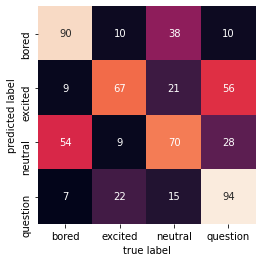

In [59]:
sns.heatmap(x,square=True, annot=True, fmt='d', cbar=False,
            xticklabels = tones,
            yticklabels = tones)
plt.xlabel('true label')
plt.ylabel('predicted label')

In [60]:
print(classification_report(y_val, yv_p))

              precision    recall  f1-score   support

       bored       0.56      0.61      0.58       148
     excited       0.62      0.44      0.51       153
     neutral       0.49      0.43      0.46       161
    question       0.50      0.68      0.58       138

    accuracy                           0.54       600
   macro avg       0.54      0.54      0.53       600
weighted avg       0.54      0.54      0.53       600



In [61]:
print(classification_report(y_train, yt_p))

              precision    recall  f1-score   support

       bored       0.62      0.64      0.63       362
     excited       0.57      0.45      0.50       329
     neutral       0.54      0.49      0.51       379
    question       0.58      0.75      0.65       330

    accuracy                           0.58      1400
   macro avg       0.58      0.58      0.57      1400
weighted avg       0.58      0.58      0.57      1400



Now we ware building our next model to check if we can get higher accuracy than the SVM model.

**RandomForest**

In [62]:
from sklearn.ensemble import RandomForestClassifier

In the above cell we used sklearn to load our library and in the next cell we are again using GridDearch Cv to tune our hyperparameters.

We are tuning the following Parameters:
max_depth: The maximum depth of the tree.
criterion: The funtion to measure the quality of a split. Gini or Entropy, default is gini.

n_estimators: The number of trees in our forest.
bootstrap: Whether bootstrap samples are used when building trees defaultvalue is true
class_weight: weight associate with the classes. (“balanced”, “balanced_subsample”) default is none.

In [63]:
parameters = {
    'max_depth': [7,8,9,10],
    'criterion': ['gini', 'entropy'],
    'n_estimators':[200,300,400],
    'bootstrap': ['False'],
    'class_weight': ['balanced', 'balanced_subsample']
}

In [64]:
grid_rf = RandomForestClassifier()
grid_forest = GridSearchCV(grid_rf, parameters, n_jobs=-1)

grid_forest.fit(X_train,y_train)

yt_p = grid_forest.predict(X_train)
yv_p = grid_forest.predict(X_val)


In [65]:
grid_forest.best_score_

0.5235714285714286

In [66]:
grid_forest.best_params_

{'bootstrap': 'False',
 'class_weight': 'balanced_subsample',
 'criterion': 'gini',
 'max_depth': 7,
 'n_estimators': 300}

In the above blocks of code we got out best score and our best parameters which we will use ot build our model.

In [79]:

clf_1 = RandomForestClassifier(max_depth=7,  criterion='gini', n_estimators=300, bootstrap=False, class_weight='balanced_subsample', 
                             n_jobs=-1)

In [80]:
clf_1.fit(X_train, y_train
        )

RandomForestClassifier(bootstrap=False, ccp_alpha=0.0,
                       class_weight='balanced_subsample', criterion='gini',
                       max_depth=7, max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=300, n_jobs=-1, oob_score=False,
                       random_state=None, verbose=0, warm_start=False)

In [81]:
yt_p = clf_1.predict(X_train)
yv_p = clf_1.predict(X_val)

print('Training Accuracy', np.mean(yt_p==y_train))
print('Validation  Accuracy', np.mean(yv_p==y_val))

Training Accuracy 0.73
Validation  Accuracy 0.5416666666666666


After using the best parameters we are getting 54% accuracy for our validation data but Training Accuracy is 73% which is overfitting. For that we will try again to build the model with normalised dataset.

In the below cell I have plotted the confusion matrix and classifiaction report of the RandomForest Model.

In [82]:
x = metrics.confusion_matrix(y_val, yv_p, labels=['bored', 'excited', 'neutral', 'question'])
y = metrics.confusion_matrix(y_train, yt_p, labels=['bored', 'excited', 'neutral', 'question'])
tones = ['bored', 'excited', 'neutral', 'question']

Text(91.68, 0.5, 'predicted label')

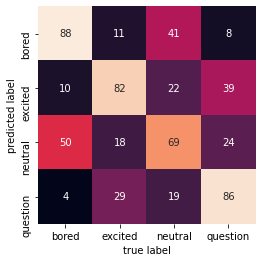

In [83]:
sns.heatmap(x,square=True, annot=True, fmt='d', cbar=False,
            xticklabels = tones,
            yticklabels = tones)
plt.xlabel('true label')
plt.ylabel('predicted label')

In [84]:
print(classification_report(y_val, yv_p))

              precision    recall  f1-score   support

       bored       0.58      0.59      0.59       148
     excited       0.59      0.54      0.56       153
     neutral       0.46      0.43      0.44       161
    question       0.55      0.62      0.58       138

    accuracy                           0.54       600
   macro avg       0.54      0.55      0.54       600
weighted avg       0.54      0.54      0.54       600



In [85]:
print(classification_report(y_train, yt_p))

              precision    recall  f1-score   support

       bored       0.76      0.71      0.74       362
     excited       0.72      0.70      0.71       329
     neutral       0.72      0.70      0.71       379
    question       0.72      0.81      0.76       330

    accuracy                           0.73      1400
   macro avg       0.73      0.73      0.73      1400
weighted avg       0.73      0.73      0.73      1400



**RandomForest on Normalised Data**

Now we will try to build our model on normlaised dataset to see if it overcomes overfitting.

In [86]:
parameters = {
    'max_depth': [7,8,9,10],
    'criterion': ['gini', 'entropy'],
    'n_estimators':[200,300,400],
    'bootstrap': ['False'],
    'random_state': [2,3,4],
    'class_weight': ['balanced', 'balanced_subsample']
}

In [87]:
grid_rfnorm = RandomForestClassifier()
grid_forestnorm = GridSearchCV(grid_rfnorm, parameters, n_jobs=-1)

grid_forestnorm.fit(X_train_normalised,y_train)

yt_p = grid_forestnorm.predict(X_train_normalised)  
yv_p = grid_forestnorm.predict(X_val_normalised)

In [88]:
grid_forestnorm.best_params_

{'bootstrap': 'False',
 'class_weight': 'balanced_subsample',
 'criterion': 'gini',
 'max_depth': 7,
 'n_estimators': 300,
 'random_state': 2}

In [89]:
grid_forestnorm.best_score_

0.5292857142857142

In [90]:

clf = RandomForestClassifier(max_depth=7, random_state=2, criterion='gini', n_estimators=300, bootstrap=False, class_weight='balanced_subsample',
                             n_jobs=-1)

In [91]:
clf.fit(X_train_normalised, y_train
        )

RandomForestClassifier(bootstrap=False, ccp_alpha=0.0,
                       class_weight='balanced_subsample', criterion='gini',
                       max_depth=7, max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=300, n_jobs=-1, oob_score=False,
                       random_state=2, verbose=0, warm_start=False)

In [92]:
yt_p = clf.predict(X_train_normalised)
yv_p = clf.predict(X_val_normalised)

print('Training Accuracy', np.mean(yt_p==y_train))
print('Validation  Accuracy', np.mean(yv_p==y_val))

Training Accuracy 0.7221428571428572
Validation  Accuracy 0.545


Even after using normalised predictors the model we can clearly see that the moedel is still overfitting.

In [93]:
x = metrics.confusion_matrix(y_val, yv_p, labels=['bored', 'excited', 'neutral', 'question'])
y = metrics.confusion_matrix(y_train, yt_p, labels=['bored', 'excited', 'neutral', 'question'])
tones = ['bored', 'excited', 'neutral', 'question']

Text(91.68, 0.5, 'predicted label')

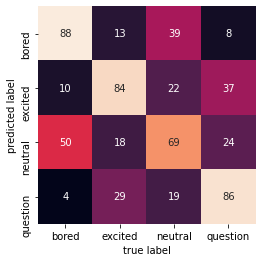

In [94]:
sns.heatmap(x,square=True, annot=True, fmt='d', cbar=False,
            xticklabels = tones,
            yticklabels = tones)
plt.xlabel('true label')
plt.ylabel('predicted label')

Text(91.68, 0.5, 'predicted label')

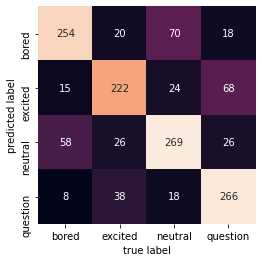

In [97]:
sns.heatmap(y,square=True, annot=True, fmt='d', cbar=False,
            xticklabels = tones,
            yticklabels = tones)
plt.xlabel('true label')
plt.ylabel('predicted label')

In [98]:
print(classification_report(y_val, yv_p))

              precision    recall  f1-score   support

       bored       0.58      0.59      0.59       148
     excited       0.58      0.55      0.57       153
     neutral       0.46      0.43      0.45       161
    question       0.55      0.62      0.59       138

    accuracy                           0.55       600
   macro avg       0.55      0.55      0.55       600
weighted avg       0.54      0.55      0.54       600



In [99]:
print(classification_report(y_train, yt_p))

              precision    recall  f1-score   support

       bored       0.76      0.70      0.73       362
     excited       0.73      0.67      0.70       329
     neutral       0.71      0.71      0.71       379
    question       0.70      0.81      0.75       330

    accuracy                           0.72      1400
   macro avg       0.72      0.72      0.72      1400
weighted avg       0.72      0.72      0.72      1400



**KNN**

Here we are building KNeighborsClassifier to again check if we can get higher accuracy for our dataset.

Here again we are starting with our hyperparameter tuning. 
WE are tuning the following hyperparameters.

n_neighbors: Number of neighbors to use for classifying.

leaf_size: This affects the speed of the construction and memory required to store the tree.


In [100]:
parameters= {
    'n_neighbors': [50,60,70,80,90],
    
    'leaf_size': [1,5,10,15,25]
}

In [101]:
from sklearn.neighbors import KNeighborsClassifier
model_kn  = KNeighborsClassifier()

grid_kn = GridSearchCV(model_kn,parameters, n_jobs=-1)
grid_kn.fit(X_train,y_train)

yt_p = grid_kn.predict(X_train)
yv_p = grid_kn.predict(X_val)

print('Training Accuracy', np.mean(yt_p==y_train))
print('Validation  Accuracy', np.mean(yv_p==y_val))

Training Accuracy 0.4907142857142857
Validation  Accuracy 0.5016666666666667


In [102]:
grid_kn.best_params_

{'leaf_size': 1, 'n_neighbors': 50}

In [103]:
grid_kn.best_score_

0.4642857142857143

Here we are getting our best score and best params which we will use to build our model.

In [104]:
knn1 = KNeighborsClassifier(n_neighbors=50,leaf_size=1, n_jobs=-1)

In [105]:
knn1.fit(X_train,y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=1, metric='minkowski',
                     metric_params=None, n_jobs=-1, n_neighbors=50, p=2,
                     weights='uniform')

In [106]:
yt_p = knn1.predict(X_train)
yv_p = knn1.predict(X_val)

print('Training Accuracy', np.mean(yt_p==y_train))
print('Validation  Accuracy', np.mean(yv_p==y_val))

Training Accuracy 0.4907142857142857
Validation  Accuracy 0.5016666666666667


Here we can see that we are getting 50% accuracy for our validation data and 49% for our Training accuracy.

In [107]:
x = metrics.confusion_matrix(y_val, yv_p, labels=['bored', 'excited', 'neutral', 'question'])
y = metrics.confusion_matrix(y_train, yt_p, labels=['bored', 'excited', 'neutral', 'question'])
tones = ['bored', 'excited', 'neutral', 'question']

Text(91.68, 0.5, 'predicted label')

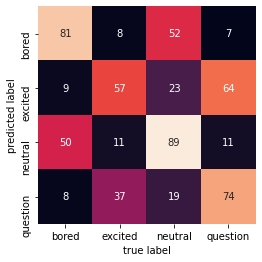

In [108]:
sns.heatmap(x,square=True, annot=True, fmt='d', cbar=False,
            xticklabels = tones,
            yticklabels = tones)
plt.xlabel('true label')
plt.ylabel('predicted label')

In [109]:
print(classification_report(y_val, yv_p))

              precision    recall  f1-score   support

       bored       0.55      0.55      0.55       148
     excited       0.50      0.37      0.43       153
     neutral       0.49      0.55      0.52       161
    question       0.47      0.54      0.50       138

    accuracy                           0.50       600
   macro avg       0.50      0.50      0.50       600
weighted avg       0.50      0.50      0.50       600



In [110]:
print(classification_report(y_train, yt_p))

              precision    recall  f1-score   support

       bored       0.58      0.56      0.57       362
     excited       0.43      0.33      0.38       329
     neutral       0.46      0.52      0.49       379
    question       0.48      0.54      0.50       330

    accuracy                           0.49      1400
   macro avg       0.49      0.49      0.49      1400
weighted avg       0.49      0.49      0.49      1400



KNN on Normalised Data

Here again I am trying to use normalised data to build our model.

In [111]:
parameters= {
    'n_neighbors': [30,40,50],
    'weights': ['distance'],
    'p': [1,2,3]
}

In [112]:
model_kn1  = KNeighborsClassifier()

grid_kn1 = GridSearchCV(model_kn1,parameters, n_jobs=-1)
grid_kn1.fit(X_train_normalised,y_train)

yt_p = grid_kn1.predict(X_train_normalised)
yv_p = grid_kn1.predict(X_val_normalised)

print('Training Accuracy', np.mean(yt_p==y_train))
print('Validation  Accuracy', np.mean(yv_p==y_val))

Training Accuracy 1.0
Validation  Accuracy 0.5383333333333333


In [113]:
grid_kn1.best_params_

{'n_neighbors': 50, 'p': 1, 'weights': 'distance'}

In [114]:
grid_kn1.best_score_

0.4928571428571429

In [117]:

model  = KNeighborsClassifier(n_neighbors=50, p=1)
model.fit(X_train,y_train)

yt_p = model.predict(X_train)
yv_p = model.predict(X_val)

print('Training Accuracy', np.mean(yt_p==y_train))
print('Validation  Accuracy', np.mean(yv_p==y_val))

Training Accuracy 0.49214285714285716
Validation  Accuracy 0.505


Here can we conclude that there is very slight increase in trianing and validation accuracies comparing it with the knn model without normalised data.

In [118]:
x = metrics.confusion_matrix(y_val, yv_p, labels=['bored', 'excited', 'neutral', 'question'])
y = metrics.confusion_matrix(y_train, yt_p, labels=['bored', 'excited', 'neutral', 'question'])
tones = ['bored', 'excited', 'neutral', 'question']

Text(91.68, 0.5, 'predicted label')

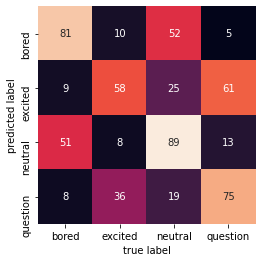

In [119]:
sns.heatmap(x,square=True, annot=True, fmt='d', cbar=False,
            xticklabels = tones,
            yticklabels = tones)
plt.xlabel('true label')
plt.ylabel('predicted label')

In [120]:
print(classification_report(y_val, yv_p))

              precision    recall  f1-score   support

       bored       0.54      0.55      0.55       148
     excited       0.52      0.38      0.44       153
     neutral       0.48      0.55      0.51       161
    question       0.49      0.54      0.51       138

    accuracy                           0.51       600
   macro avg       0.51      0.51      0.50       600
weighted avg       0.51      0.51      0.50       600



In [121]:
print(classification_report(y_train, yt_p))

              precision    recall  f1-score   support

       bored       0.57      0.59      0.58       362
     excited       0.43      0.32      0.37       329
     neutral       0.48      0.50      0.49       379
    question       0.47      0.55      0.51       330

    accuracy                           0.49      1400
   macro avg       0.49      0.49      0.49      1400
weighted avg       0.49      0.49      0.49      1400



**KNN with Different Distance Metric**

Here I have tried building the knn with the different distance parameter.

In [122]:

model  = KNeighborsClassifier(n_neighbors=50, p=1, weights='distance')
model.fit(X_train,y_train)

yt_p = model.predict(X_train)
yv_p = model.predict(X_val)

print('Training Accuracy', np.mean(yt_p==y_train))
print('Validation  Accuracy', np.mean(yv_p==y_val))

Training Accuracy 1.0
Validation  Accuracy 0.5033333333333333


We can see that using distanc method in our model the training accuracy went upto 100 percent and validation remains 50%, which is clearly overfitting.

**Naive Bayes**

Now we are trying to build a Naive Bayes Classifier.

In [123]:
from sklearn.naive_bayes import GaussianNB

In [124]:
gnb = GaussianNB()

In [125]:
gnb.fit(X_train,y_train)

yt_p = gnb.predict(X_train)
yv_p = gnb.predict(X_val)

print('Training Accuracy', np.mean(yt_p==y_train))
print('Validation  Accuracy', np.mean(yv_p==y_val))

Training Accuracy 0.46
Validation  Accuracy 0.46166666666666667


Here we can see that the training and validation are almost same which is 46%.

In [126]:
x = metrics.confusion_matrix(y_val, yv_p, labels=['bored', 'excited', 'neutral', 'question'])
y = metrics.confusion_matrix(y_train, yt_p, labels=['bored', 'excited', 'neutral', 'question'])
tones = ['bored', 'excited', 'neutral', 'question']

Text(91.68, 0.5, 'predicted label')

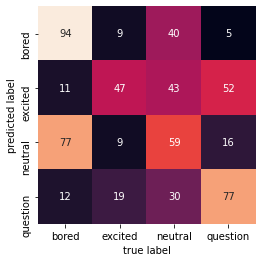

In [127]:
sns.heatmap(x,square=True, annot=True, fmt='d', cbar=False,
            xticklabels = tones,
            yticklabels = tones)
plt.xlabel('true label')
plt.ylabel('predicted label')

In [128]:
print(classification_report(y_val, yv_p))

              precision    recall  f1-score   support

       bored       0.48      0.64      0.55       148
     excited       0.56      0.31      0.40       153
     neutral       0.34      0.37      0.35       161
    question       0.51      0.56      0.53       138

    accuracy                           0.46       600
   macro avg       0.48      0.47      0.46       600
weighted avg       0.47      0.46      0.45       600



In [129]:
print(classification_report(y_train, yt_p))

              precision    recall  f1-score   support

       bored       0.51      0.60      0.55       362
     excited       0.47      0.26      0.33       329
     neutral       0.37      0.44      0.40       379
    question       0.51      0.53      0.52       330

    accuracy                           0.46      1400
   macro avg       0.47      0.46      0.45      1400
weighted avg       0.46      0.46      0.45      1400



Naive Bayes on Normalised Data

Here I am again applying the Naive Bayes model on our normalised data.

In [130]:
gnb.fit(X_train_normalised,y_train)

yt_p = gnb.predict(X_train_normalised)
yv_p = gnb.predict(X_val_normalised)

print('Training Accuracy', np.mean(yt_p==y_train))
print('Validation  Accuracy', np.mean(yv_p==y_val))

Training Accuracy 0.46214285714285713
Validation  Accuracy 0.46


Here again I am getting 46% accuracy for both training and validation data.

In [131]:
x = metrics.confusion_matrix(y_val, yv_p, labels=['bored', 'excited', 'neutral', 'question'])
y = metrics.confusion_matrix(y_train, yt_p, labels=['bored', 'excited', 'neutral', 'question'])
tones = ['bored', 'excited', 'neutral', 'question']

Text(91.68, 0.5, 'predicted label')

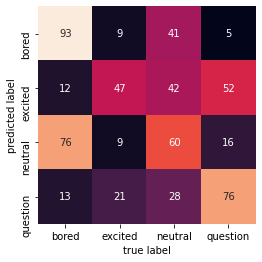

In [132]:
sns.heatmap(x,square=True, annot=True, fmt='d', cbar=False,
            xticklabels = tones,
            yticklabels = tones)
plt.xlabel('true label')
plt.ylabel('predicted label')

In [133]:
print(classification_report(y_val, yv_p))

              precision    recall  f1-score   support

       bored       0.48      0.63      0.54       148
     excited       0.55      0.31      0.39       153
     neutral       0.35      0.37      0.36       161
    question       0.51      0.55      0.53       138

    accuracy                           0.46       600
   macro avg       0.47      0.46      0.46       600
weighted avg       0.47      0.46      0.45       600



In [134]:
print(classification_report(y_train, yt_p))

              precision    recall  f1-score   support

       bored       0.52      0.60      0.56       362
     excited       0.47      0.26      0.33       329
     neutral       0.37      0.45      0.41       379
    question       0.51      0.53      0.52       330

    accuracy                           0.46      1400
   macro avg       0.47      0.46      0.45      1400
weighted avg       0.46      0.46      0.45      1400



**Logistic Regression**

Now I am applying Logistic Regression and starting with the hyperparameter tuning.

In [135]:
from sklearn.linear_model import LogisticRegression

I am tuning the following hyperparametrs

penalty: It is used to specify the norms used in the penalization.

C :Regularisatipn Strength

class_weight: Weights associated with classes 

solver: Algorithm to use in the optimization problem

multi_class: ('auto' ,'ovr', 'multinomaila) default is auto


In [136]:
parameters= {
    'penalty': ['l1', 'elasticnet', 'none'],
    'C': [0.1,2,3,4,5],
    'class_weight': ['dict', 'balanced'],
    'solver': ['newton_cg', 'liblinear', 'sag', 'saga'],
    'multi_class': ['multinomial'],

}

In [137]:
lgr = LogisticRegression()

In [138]:
grid_lgr = GridSearchCV(lgr, parameters, n_jobs=-1)
grid_lgr.fit(X_train,y_train)
yt_p = grid_lgr.predict(X_train)
yv_p = grid_lgr.predict(X_val)

print('Training Accuracy', np.mean(yt_p==y_train))
print('Validation  Accuracy', np.mean(yv_p==y_val))

Training Accuracy 0.45785714285714285
Validation  Accuracy 0.4666666666666667


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1505: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


In [139]:
grid_lgr.best_params_

{'C': 0.1,
 'class_weight': 'balanced',
 'multi_class': 'multinomial',
 'penalty': 'none',
 'solver': 'sag'}

In [140]:
grid_lgr.best_score_

0.45714285714285713

In [141]:
lgr = LogisticRegression(C=0.1, class_weight='balanced', multi_class='multinomial',  solver='sag')
lgr.fit(X_train,y_train)
yt_p = lgr.predict(X_train)
yv_p = lgr.predict(X_val) 

print('Training Accuracy', np.mean(yt_p==y_train))
print('Validation  Accuracy', np.mean(yv_p==y_val))

Training Accuracy 0.4585714285714286
Validation  Accuracy 0.4666666666666667


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Above we can see that validation accuracy is slightly more than the training data.

In [142]:
x = metrics.confusion_matrix(y_val, yv_p, labels=['bored', 'excited', 'neutral', 'question'])
y = metrics.confusion_matrix(y_train, yt_p, labels=['bored', 'excited', 'neutral', 'question'])
tones = ['bored', 'excited', 'neutral', 'question']

Text(91.68, 0.5, 'predicted label')

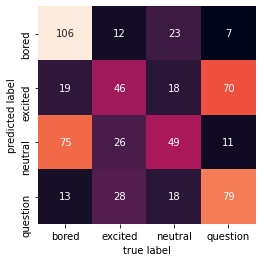

In [143]:
sns.heatmap(x,square=True, annot=True, fmt='d', cbar=False,
            xticklabels = tones,
            yticklabels = tones)
plt.xlabel('true label')
plt.ylabel('predicted label')

In [144]:
print(classification_report(y_val, yv_p))

              precision    recall  f1-score   support

       bored       0.50      0.72      0.59       148
     excited       0.41      0.30      0.35       153
     neutral       0.45      0.30      0.36       161
    question       0.47      0.57      0.52       138

    accuracy                           0.47       600
   macro avg       0.46      0.47      0.45       600
weighted avg       0.46      0.47      0.45       600



In [145]:
print(classification_report(y_train, yt_p))

              precision    recall  f1-score   support

       bored       0.49      0.73      0.59       362
     excited       0.35      0.29      0.31       329
     neutral       0.46      0.26      0.33       379
    question       0.49      0.56      0.52       330

    accuracy                           0.46      1400
   macro avg       0.45      0.46      0.44      1400
weighted avg       0.45      0.46      0.44      1400



Logistic Regression on Normalised Data

Again I ma trying to build the model on the normalised data.

In [146]:
parameters= {
    'penalty': ['l1', 'elasticnet', 'none'],
    'C': [0.1,2,3,4,5],
    'class_weight': ['dict', 'balanced'],
    'solver': ['newton_cg', 'liblinear', 'sag', 'saga'],
    'multi_class': ['multinomial'],

}

In [147]:
lgr = LogisticRegression()

In [148]:
grid_lgr = GridSearchCV(lgr, parameters, n_jobs=-1)
grid_lgr.fit(X_train_normalised,y_train)
yt_p = grid_lgr.predict(X_train_normalised)
yv_p = grid_lgr.predict(X_val_normalised)

print('Training Accuracy', np.mean(yt_p==y_train))
print('Validation  Accuracy', np.mean(yv_p==y_val))

Training Accuracy 0.5
Validation  Accuracy 0.5016666666666667


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1505: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "


Here we can see that we got equal accuracies for trainng and validation data which is 50%, which is quite better than the model without normalised.

In [150]:
grid_lgr.best_score_

0.4878571428571428

In [151]:
grid_lgr.best_params_

{'C': 0.1,
 'class_weight': 'balanced',
 'multi_class': 'multinomial',
 'penalty': 'none',
 'solver': 'sag'}

In [156]:
lgr = LogisticRegression(C=0.1, class_weight='balanced', multi_class='multinomial',solver='sag')
lgr.fit(X_train_normalised,y_train)
yt_p = lgr.predict(X_train_normalised)
yv_p = lgr.predict(X_val_normalised)

print('Training Accuracy', np.mean(yt_p==y_train))
print('Validation  Accuracy', np.mean(yv_p==y_val))

Training Accuracy 0.49642857142857144
Validation  Accuracy 0.49833333333333335


In [157]:
x = metrics.confusion_matrix(y_val, yv_p, labels=['bored', 'excited', 'neutral', 'question'])
y = metrics.confusion_matrix(y_train, yt_p, labels=['bored', 'excited', 'neutral', 'question'])
tones = ['bored', 'excited', 'neutral', 'question']

Text(91.68, 0.5, 'predicted label')

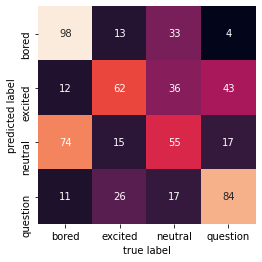

In [158]:
sns.heatmap(x,square=True, annot=True, fmt='d', cbar=False,
            xticklabels = tones,
            yticklabels = tones)
plt.xlabel('true label')
plt.ylabel('predicted label')

In [159]:
print(classification_report(y_val, yv_p))

              precision    recall  f1-score   support

       bored       0.50      0.66      0.57       148
     excited       0.53      0.41      0.46       153
     neutral       0.39      0.34      0.36       161
    question       0.57      0.61      0.59       138

    accuracy                           0.50       600
   macro avg       0.50      0.50      0.50       600
weighted avg       0.50      0.50      0.49       600



In [160]:
print(classification_report(y_train, yt_p))

              precision    recall  f1-score   support

       bored       0.52      0.64      0.57       362
     excited       0.44      0.36      0.40       329
     neutral       0.45      0.40      0.43       379
    question       0.55      0.59      0.57       330

    accuracy                           0.50      1400
   macro avg       0.49      0.50      0.49      1400
weighted avg       0.49      0.50      0.49      1400



**MultiLayer Perceptron**

Here I am trying to build a MulitLayer Perceptron Classifier model to achieve higehr accuracy.

In [161]:
from sklearn.neural_network import MLPClassifier

In [162]:
clf = MLPClassifier(random_state=1, max_iter=300).fit(X_train, y_train)

In [163]:
yt_p = lgr.predict(X_train)
yv_p = lgr.predict(X_val)

print('Training Accuracy', np.mean(yt_p==y_train))
print('Validation  Accuracy', np.mean(yv_p==y_val))

Training Accuracy 0.2357142857142857
Validation  Accuracy 0.23333333333333334


I got only 23% accuracy on both models with the default parameters now trying to increase the accuracy by hyper parameter tuning.

Tuning the below parameters.

activation: Activation fucniton for hidden layer.

solver: For weight optimization.

max_iter: Maximum number of iterations.

random_state: It Determines random number generation for weights and bias initialization


In [179]:
parameters = {
    'activation': ['logistic', 'tanh'],
    'solver': ['lbfgs', 'sgd'],
    'max_iter': [300,400,500],
    'random_state': [1,2,3]
    
}

In [218]:
clf_grid = MLPClassifier()

In [190]:
grid_mlp = GridSearchCV(clf_grid, parameters, n_jobs=-1)
grid_mlp.fit(X_train,y_train)


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


GridSearchCV(cv=None, error_score=nan,
             estimator=MLPClassifier(activation='relu', alpha=0.0001,
                                     batch_size='auto', beta_1=0.9,
                                     beta_2=0.999, early_stopping=False,
                                     epsilon=1e-08, hidden_layer_sizes=(100,),
                                     learning_rate='constant',
                                     learning_rate_init=0.001, max_fun=15000,
                                     max_iter=200, momentum=0.9,
                                     n_iter_no_change=10,
                                     nesterovs_momentum=True, power_t=0.5,
                                     random_state=None, shuffle=True,
                                     solver='adam', tol=0.0001,
                                     validation_fraction=0.1, verbose=False,
                                     warm_start=False),
             iid='deprecated', n_jobs=-1,
             param_grid

In [191]:
grid_mlp.best_score_

0.49857142857142855

In [192]:
grid_mlp.best_params_

{'activation': 'tanh', 'max_iter': 500, 'random_state': 1, 'solver': 'lbfgs'}

In [219]:
clf = MLPClassifier(max_iter=500, solver='lbfgs', activation='tanh', random_state=1).fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


In [220]:
yt_p = clf.predict(X_train)
yv_p = clf.predict(X_val)

print('Training Accuracy', np.mean(yt_p==y_train))
print('Validation  Accuracy', np.mean(yv_p==y_val))

Training Accuracy 0.5128571428571429
Validation  Accuracy 0.49166666666666664


Here I am gettign 49% accuracy for our validation data and 51% for our training Data.

In [221]:
x = metrics.confusion_matrix(y_val, yv_p, labels=['bored', 'excited', 'neutral', 'question'])
y = metrics.confusion_matrix(y_train, yt_p, labels=['bored', 'excited', 'neutral', 'question'])
tones = ['bored', 'excited', 'neutral', 'question']

Text(91.68, 0.5, 'predicted label')

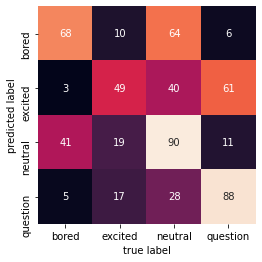

In [222]:
sns.heatmap(x,square=True, annot=True, fmt='d', cbar=False,
            xticklabels = tones,
            yticklabels = tones)
plt.xlabel('true label')
plt.ylabel('predicted label')

In [223]:
print(classification_report(y_val, yv_p))

              precision    recall  f1-score   support

       bored       0.58      0.46      0.51       148
     excited       0.52      0.32      0.40       153
     neutral       0.41      0.56      0.47       161
    question       0.53      0.64      0.58       138

    accuracy                           0.49       600
   macro avg       0.51      0.49      0.49       600
weighted avg       0.51      0.49      0.49       600



In [224]:
print(classification_report(y_train, yt_p))

              precision    recall  f1-score   support

       bored       0.62      0.48      0.54       362
     excited       0.47      0.31      0.37       329
     neutral       0.47      0.61      0.53       379
    question       0.52      0.63      0.57       330

    accuracy                           0.51      1400
   macro avg       0.52      0.51      0.50      1400
weighted avg       0.52      0.51      0.51      1400



MultiLayer Perceptron on Normalised Data.

In [195]:
parameters = {
    'activation': ['logistic', 'tanh'],
    'solver': ['lbfgs', 'sgd'],
    'max_iter': [300,400,500],
    'random_state': [1,2,3]
    
}

In [196]:
clf_grid = MLPClassifier()

In [197]:
grid_mlp = GridSearchCV(clf_grid, parameters, n_jobs=-1)
grid_mlp.fit(X_train_normalised,y_train)


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


GridSearchCV(cv=None, error_score=nan,
             estimator=MLPClassifier(activation='relu', alpha=0.0001,
                                     batch_size='auto', beta_1=0.9,
                                     beta_2=0.999, early_stopping=False,
                                     epsilon=1e-08, hidden_layer_sizes=(100,),
                                     learning_rate='constant',
                                     learning_rate_init=0.001, max_fun=15000,
                                     max_iter=200, momentum=0.9,
                                     n_iter_no_change=10,
                                     nesterovs_momentum=True, power_t=0.5,
                                     random_state=None, shuffle=True,
                                     solver='adam', tol=0.0001,
                                     validation_fraction=0.1, verbose=False,
                                     warm_start=False),
             iid='deprecated', n_jobs=-1,
             param_grid

In [198]:
grid_mlp.best_score_

0.5264285714285714

In [199]:
grid_mlp.best_params_

{'activation': 'logistic',
 'max_iter': 300,
 'random_state': 1,
 'solver': 'lbfgs'}

In [ ]:
clf = MLPClassifier(max_iter=300, solver='lbfgs', activation='logistic',random_state=1).fit(X_train, y_train)
yt_p = clf.predict(X_train)
yv_p = clf.predict(X_val)



In [213]:
print('Training Accuracy', np.mean(yt_p==y_train))
print('Validation  Accuracy', np.mean(yv_p==y_val))

Training Accuracy 0.5021428571428571
Validation  Accuracy 0.48


Using normalsied data on the model the accuracy slightly drops.

In [214]:
x = metrics.confusion_matrix(y_val, yv_p, labels=['bored', 'excited', 'neutral', 'question'])
y = metrics.confusion_matrix(y_train, yt_p, labels=['bored', 'excited', 'neutral', 'question'])
tones = ['bored', 'excited', 'neutral', 'question']

Text(91.68, 0.5, 'predicted label')

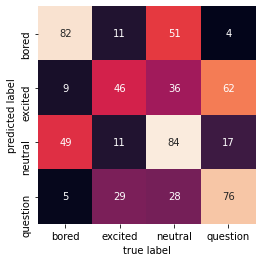

In [215]:
sns.heatmap(x,square=True, annot=True, fmt='d', cbar=False,
            xticklabels = tones,
            yticklabels = tones)
plt.xlabel('true label')
plt.ylabel('predicted label')

In [216]:
print(classification_report(y_val, yv_p))

              precision    recall  f1-score   support

       bored       0.57      0.55      0.56       148
     excited       0.47      0.30      0.37       153
     neutral       0.42      0.52      0.47       161
    question       0.48      0.55      0.51       138

    accuracy                           0.48       600
   macro avg       0.48      0.48      0.48       600
weighted avg       0.48      0.48      0.47       600



In [217]:
print(classification_report(y_train, yt_p))

              precision    recall  f1-score   support

       bored       0.59      0.57      0.58       362
     excited       0.44      0.29      0.35       329
     neutral       0.47      0.54      0.50       379
    question       0.49      0.59      0.54       330

    accuracy                           0.50      1400
   macro avg       0.50      0.50      0.49      1400
weighted avg       0.50      0.50      0.50      1400



Now trying to extract more features and experimenting with it to increase the accuracy of the model.

We got the maximum accuracy for our first modek which was SVM now trying to extract more features and expreimenting with them.

Here again we are using the getXy function but with more features.

In [225]:
def getXy(files,labels_file,scale_audio=False, onlySingleDigit=False):
  X,y =[],[]
  for file in tqdm(files):
    fileID = file.split('/')[-1]
    yi = list(labels_file[labels_file['File ID']==fileID]['intonation'])[0]
    if onlySingleDigit and yi>9:
      continue
    else:
      fs = None # if None, fs would be 22050
      x, fs = librosa.load(file,sr=fs)
      if scale_audio: x = x/np.max(np.abs(x))
      f0, voiced_flag = getPitch(x,fs,winLen=0.02)
      
      power = np.sum(x**2)/len(x)
      pitch_mean = np.nanmean(f0) if np.mean(np.isnan(f0))<1 else 0
      pitch_std  = np.nanstd(f0) if np.mean(np.isnan(f0))<1 else 0
      voiced_fr = np.mean(voiced_flag)
      #onset = np.mean(librosa.onset.onset_detect(x,fs))
      mfccs = np.mean(librosa.feature.mfcc(x, sr=fs))
      #zcr = np.mean(librosa.feature.zero_crossing_rate(x))
      #spc = np.mean(librosa.feature.spectral_centroid(x, fs))
      #spr = np.mean(librosa.feature.spectral_rolloff(x, fs))
      #mf1 = np.mean(mfccs)

      xi = [power, pitch_mean, pitch_std,voiced_fr ,mfccs]
      X.append(xi)
      y.append(yi)
  return np.array(X),np.array(y)

I tried with many features like onset, zero crossing rate, mfcc, spectral centroid and spectral rolloff , but mfcc gave better results comparing to all teh featues.

Here we again get our files with our extra feature which is mfcc.

In [226]:
X,y = getXy(files[:2000],labels_file=labels,scale_audio=True, onlySingleDigit=False)
# If you want to use all 20000 files, run next line instead
#X,y = getXy(files,labels_file=labels,scale_audio=True, onlySingleDigit=True)

100%|██████████| 2000/2000 [11:14<00:00,  2.97it/s]


In [227]:
print('The shape of X is', X.shape) 
print('The shape of y is', y.shape)
print('The labels vector is', y)

The shape of X is (2000, 5)
The shape of y is (2000,)
The labels vector is ['bored' 'question' 'excited' ... 'excited' 'excited' 'question']


We can see in the above X.shape we have 5 features.

In [228]:
# If nan sample, remove them
if np.sum(np.isnan(X)):
  idx = np.isnan(X).sum(1)>0
  X = X[~idx]
  y = y[~idx]
print(np.sum(np.isnan(X)))

0


We are again checking if we have any NAN files.

For preprocessing our features now I am using Standard Scaler function.
It standardize the features by removing the mean and scaling to unit variance.

In [230]:
from sklearn.preprocessing import StandardScaler

In [231]:
scaler = StandardScaler()

In [232]:
print(scaler.fit(X))

StandardScaler(copy=True, with_mean=True, with_std=True)


In [233]:
print(scaler.transform(X))

[[-0.3172691   0.66603234  0.10528229  0.25616717  0.00933893]
 [ 1.31300851  0.13387469  1.19914176 -0.31234921  0.54165877]
 [ 1.60705086 -0.651091   -0.31185523 -0.17675237  1.34489405]
 ...
 [-0.07330523 -0.14210519  0.39887928  0.89900027  0.88607148]
 [ 0.27667186  0.56854351  0.3994906   0.57523732  0.00944588]
 [ 0.69571529  0.32860062  0.38266388 -0.27442114  0.20859346]]


In [234]:
from sklearn import svm
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X,y,test_size=0.3)
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((1400, 5), (600, 5), (1400,), (600,))

In [235]:
'''
mean = X_train.mean(0)
sd =  X_train.std(0)

X_train_normalised = (X_train-mean)/sd
X_val_normalised  = (X_val-mean)/sd'''

In [ ]:
Here I tried to model with the normlaised features and one with the Standard scaled features.

SVM with StandardScaler

In [236]:
parameters = {
    
    'C': [ 2,2.5, 3],
    'gamma': [ 0.2, 0.1, 0.01,0.02, 'scale'],
    'kernel': ['rbf', 'linear', 'sigmoid'],
    'class_weight': ['balanced']

}
grid_model = svm.SVC()
grid_svc = GridSearchCV(grid_model, parameters, n_jobs=-1)

grid_svc.fit(X_train,y_train)

yt_p = grid_svc.predict(X_train)
yv_p = grid_svc.predict(X_val)

print('Training Accuracy', np.mean(yt_p==y_train))
print('Validation  Accuracy', np.mean(yv_p==y_val))

Training Accuracy 0.7042857142857143
Validation  Accuracy 0.5066666666666667


In [237]:
grid_svc.best_score_

0.4742857142857143

In [238]:
grid_svc.best_params_

{'C': 2, 'class_weight': 'balanced', 'gamma': 0.01, 'kernel': 'rbf'}

In [239]:
model  = svm.SVC(C=2, gamma=0.01, kernel='rbf', class_weight='balanced')
model.fit(X_train,y_train)

yt_p = model.predict(X_train)
yv_p = model.predict(X_val)

print('Training Accuracy', np.mean(yt_p==y_train))
print('Validation  Accuracy', np.mean(yv_p==y_val))

Training Accuracy 0.7042857142857143
Validation  Accuracy 0.5066666666666667


Here we can see that our SVM model is clearly overfitting with validation accuracy 50% and training Accuracy 70%.

In [240]:
x = metrics.confusion_matrix(y_val, yv_p, labels=['bored', 'excited', 'neutral', 'question'])
y = metrics.confusion_matrix(y_train, yt_p, labels=['bored', 'excited', 'neutral', 'question'])
tones = ['bored', 'excited', 'neutral', 'question']

Text(91.68, 0.5, 'predicted label')

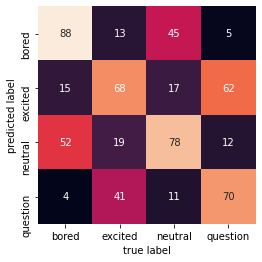

In [241]:
sns.heatmap(x,square=True, annot=True, fmt='d', cbar=False,
            xticklabels = tones,
            yticklabels = tones)
plt.xlabel('true label')
plt.ylabel('predicted label')

In [242]:
print(classification_report(y_val, yv_p))

              precision    recall  f1-score   support

       bored       0.55      0.58      0.57       151
     excited       0.48      0.42      0.45       162
     neutral       0.52      0.48      0.50       161
    question       0.47      0.56      0.51       126

    accuracy                           0.51       600
   macro avg       0.51      0.51      0.51       600
weighted avg       0.51      0.51      0.51       600



In [243]:
print(classification_report(y_train, yt_p))

              precision    recall  f1-score   support

       bored       0.68      0.72      0.70       359
     excited       0.74      0.72      0.73       320
     neutral       0.63      0.63      0.63       379
    question       0.78      0.76      0.77       342

    accuracy                           0.70      1400
   macro avg       0.71      0.71      0.71      1400
weighted avg       0.71      0.70      0.70      1400



**SVM on Normalised Data**

In [244]:
'''
parameters = {
    
    'C': [ 6,7,8,5],
    'gamma': [ 0.2, 0.1, 0.3,0.4, 'scale'],
    'kernel': ['rbf', 'linear', 'sigmoid'],
    'class_weight': ['balanced']

}
grid_model = svm.SVC()
grid_svc = GridSearchCV(grid_model, parameters, n_jobs=-1)

grid_svc.fit(X_train_normalised,y_train)

yt_p = grid_svc.predict(X_train_normalised)
yv_p = grid_svc.predict(X_val_normalised)

print('Training Accuracy', np.mean(yt_p==y_train))
print('Validation  Accuracy', np.mean(yv_p==y_val))'''

Training Accuracy 0.5742857142857143
Validation  Accuracy 0.51


Here we can see that normalise data gave around 51% on validation data and 57.4% on trianing accuracy.

In [245]:
#grid_svc.best_score_

0.5085714285714287

In [246]:
#grid_svc.best_params_

{'C': 8, 'class_weight': 'balanced', 'gamma': 0.1, 'kernel': 'rbf'}

In [247]:
'''
model  = svm.SVC(C=8, gamma=0.1, kernel='rbf', class_weight='balanced')
model.fit(X_train_normalised,y_train)

yt_p = model.predict(X_train_normalised)
yv_p = model.predict(X_val_normalised)

print('Training Accuracy', np.mean(yt_p==y_train))
print('Validation  Accuracy', np.mean(yv_p==y_val))
'''

Training Accuracy 0.5742857142857143
Validation  Accuracy 0.51


In [248]:
'''
x = metrics.confusion_matrix(y_val, yv_p, labels=['bored', 'excited', 'neutral', 'question'])
y = metrics.confusion_matrix(y_train, yt_p, labels=['bored', 'excited', 'neutral', 'question'])
tones = ['bored', 'excited', 'neutral', 'question']'''

Text(91.68, 0.5, 'predicted label')

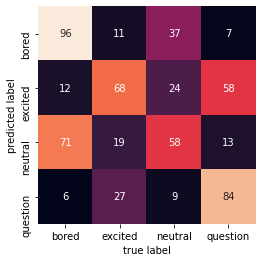

In [249]:
'''
sns.heatmap(x,square=True, annot=True, fmt='d', cbar=False,
            xticklabels = tones,
            yticklabels = tones)
plt.xlabel('true label')
plt.ylabel('predicted label')
'''

In [250]:
#print(classification_report(y_val, yv_p))

              precision    recall  f1-score   support

       bored       0.52      0.64      0.57       151
     excited       0.54      0.42      0.47       162
     neutral       0.45      0.36      0.40       161
    question       0.52      0.67      0.58       126

    accuracy                           0.51       600
   macro avg       0.51      0.52      0.51       600
weighted avg       0.51      0.51      0.50       600



In [251]:
#print(classification_report(y_train, yt_p))

              precision    recall  f1-score   support

       bored       0.57      0.67      0.62       359
     excited       0.57      0.49      0.52       320
     neutral       0.53      0.45      0.49       379
    question       0.62      0.69      0.65       342

    accuracy                           0.57      1400
   macro avg       0.57      0.58      0.57      1400
weighted avg       0.57      0.57      0.57      1400



RandomForest using StandardScaler

In [252]:
parameters = {
    'max_depth': [7,8,9,10],
    'criterion': ['gini', 'entropy'],
    'n_estimators':[200,300,400],
    'bootstrap': ['False'],
    'class_weight': ['balanced', 'balanced_subsample']
}

In [253]:
grid_rf = RandomForestClassifier()
grid_forest = GridSearchCV(grid_rf, parameters, n_jobs=-1)

grid_forest.fit(X_train,y_train)

yt_p = grid_forest.predict(X_train)
yv_p = grid_forest.predict(X_val)


In [254]:
grid_forest.best_score_

0.5392857142857144

In [255]:
grid_forest.best_params_

{'bootstrap': 'False',
 'class_weight': 'balanced_subsample',
 'criterion': 'gini',
 'max_depth': 7,
 'n_estimators': 300}

In [256]:

clf_1 = RandomForestClassifier(max_depth=7,  criterion='gini', n_estimators=300, bootstrap=False, class_weight='balanced_subsample', 
                             n_jobs=-1)


clf_1.fit(X_train, y_train
        )

yt_p = clf_1.predict(X_train)
yv_p = clf_1.predict(X_val)

print('Training Accuracy', np.mean(yt_p==y_train))
print('Validation  Accuracy', np.mean(yv_p==y_val))

Training Accuracy 0.7457142857142857
Validation  Accuracy 0.5216666666666666


Here again our model is overfitting with validation accuracy of 52.1% and Training Accuracy of 74.5%.

In [257]:
x = metrics.confusion_matrix(y_val, yv_p, labels=['bored', 'excited', 'neutral', 'question'])
y = metrics.confusion_matrix(y_train, yt_p, labels=['bored', 'excited', 'neutral', 'question'])
tones = ['bored', 'excited', 'neutral', 'question']

Text(91.68, 0.5, 'predicted label')

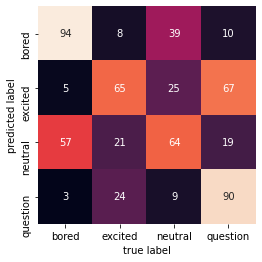

In [258]:
sns.heatmap(x,square=True, annot=True, fmt='d', cbar=False,
            xticklabels = tones,
            yticklabels = tones)
plt.xlabel('true label')
plt.ylabel('predicted label')

In [259]:
print(classification_report(y_val, yv_p))

              precision    recall  f1-score   support

       bored       0.59      0.62      0.61       151
     excited       0.55      0.40      0.46       162
     neutral       0.47      0.40      0.43       161
    question       0.48      0.71      0.58       126

    accuracy                           0.52       600
   macro avg       0.52      0.53      0.52       600
weighted avg       0.52      0.52      0.51       600



In [260]:
print(classification_report(y_train, yt_p))

              precision    recall  f1-score   support

       bored       0.78      0.74      0.76       359
     excited       0.78      0.71      0.74       320
     neutral       0.72      0.69      0.71       379
    question       0.71      0.85      0.78       342

    accuracy                           0.75      1400
   macro avg       0.75      0.75      0.75      1400
weighted avg       0.75      0.75      0.74      1400



**RandomForest on Normalised Data**

In [261]:
'''
parameters = {
    'max_depth': [7,8,9,10],
    'criterion': ['gini', 'entropy'],
    'n_estimators':[200,300,400],
    'bootstrap': ['False'],
    'class_weight': ['balanced', 'balanced_subsample']
}'''

In [262]:
'''
grid_rf = RandomForestClassifier()
grid_forest = GridSearchCV(grid_rf, parameters, n_jobs=-1)

grid_forest.fit(X_train_normalised,y_train)

yt_p = grid_forest.predict(X_train_normalised)
yv_p = grid_forest.predict(X_val_normalised)
'''

In [263]:
#grid_forest.best_params_

{'bootstrap': 'False',
 'class_weight': 'balanced',
 'criterion': 'gini',
 'max_depth': 7,
 'n_estimators': 200}

In [264]:
#grid_forest.best_score_

0.5407142857142857

In [265]:
'''
clf_1 = RandomForestClassifier(max_depth=7,  criterion='gini', n_estimators=200, bootstrap=False, class_weight='balanced', 
                             n_jobs=-1)


clf_1.fit(X_train_normalised, y_train
        )

yt_p = clf_1.predict(X_train_normalised)
yv_p = clf_1.predict(X_val_normalised)

print('Training Accuracy', np.mean(yt_p==y_train))
print('Validation  Accuracy', np.mean(yv_p==y_val))'''

Training Accuracy 0.7514285714285714
Validation  Accuracy 0.515


In [266]:
'''
x = metrics.confusion_matrix(y_val, yv_p, labels=['bored', 'excited', 'neutral', 'question'])
y = metrics.confusion_matrix(y_train, yt_p, labels=['bored', 'excited', 'neutral', 'question'])
tones = ['bored', 'excited', 'neutral', 'question']'''

Text(91.68, 0.5, 'predicted label')

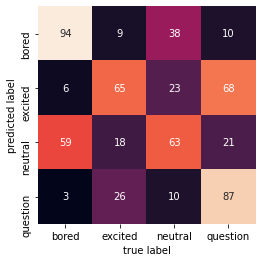

In [267]:
'''sns.heatmap(x,square=True, annot=True, fmt='d', cbar=False,
            xticklabels = tones,
            yticklabels = tones)
plt.xlabel('true label')
plt.ylabel('predicted label')'''

In [268]:
#print(classification_report(y_val, yv_p))

              precision    recall  f1-score   support

       bored       0.58      0.62      0.60       151
     excited       0.55      0.40      0.46       162
     neutral       0.47      0.39      0.43       161
    question       0.47      0.69      0.56       126

    accuracy                           0.52       600
   macro avg       0.52      0.53      0.51       600
weighted avg       0.52      0.52      0.51       600



In [269]:
#print(classification_report(y_train, yt_p))

              precision    recall  f1-score   support

       bored       0.78      0.75      0.76       359
     excited       0.78      0.72      0.75       320
     neutral       0.73      0.69      0.71       379
    question       0.72      0.86      0.78       342

    accuracy                           0.75      1400
   macro avg       0.75      0.75      0.75      1400
weighted avg       0.75      0.75      0.75      1400



**KNN using Standard Scaler**

In [270]:
parameters= {
    'n_neighbors': [50,60,70,80,90,100],
    
    'leaf_size': [1,2,3,4,5]
}

In [271]:
model_kn  = KNeighborsClassifier()

grid_kn = GridSearchCV(model_kn,parameters, n_jobs=-1)
grid_kn.fit(X_train,y_train)

yt_p = grid_kn.predict(X_train)
yv_p = grid_kn.predict(X_val)

print('Training Accuracy', np.mean(yt_p==y_train))
print('Validation  Accuracy', np.mean(yv_p==y_val))

Training Accuracy 0.505
Validation  Accuracy 0.505


In [272]:
grid_kn.best_score_

0.4714285714285714

In [273]:
grid_kn.best_params_

{'leaf_size': 1, 'n_neighbors': 50}

In [274]:
knn1 = KNeighborsClassifier(n_neighbors=50,leaf_size=1, n_jobs=-1)


knn1.fit(X_train,y_train)
yt_p = knn1.predict(X_train)
yv_p = knn1.predict(X_val)

print('Training Accuracy', np.mean(yt_p==y_train))
print('Validation  Accuracy', np.mean(yv_p==y_val))

Training Accuracy 0.505
Validation  Accuracy 0.505


**Here we are getting accuracy of 50.5% on training and validation task.**

In [275]:
x = metrics.confusion_matrix(y_val, yv_p, labels=['bored', 'excited', 'neutral', 'question'])
y = metrics.confusion_matrix(y_train, yt_p, labels=['bored', 'excited', 'neutral', 'question'])
tones = ['bored', 'excited', 'neutral', 'question']

Text(91.68, 0.5, 'predicted label')

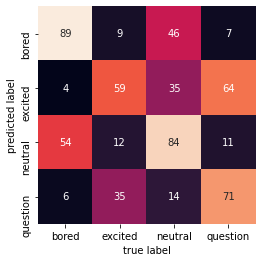

In [276]:
sns.heatmap(x,square=True, annot=True, fmt='d', cbar=False,
            xticklabels = tones,
            yticklabels = tones)
plt.xlabel('true label')
plt.ylabel('predicted label')

In [277]:
print(classification_report(y_val, yv_p))

              precision    recall  f1-score   support

       bored       0.58      0.59      0.59       151
     excited       0.51      0.36      0.43       162
     neutral       0.47      0.52      0.49       161
    question       0.46      0.56      0.51       126

    accuracy                           0.51       600
   macro avg       0.51      0.51      0.50       600
weighted avg       0.51      0.51      0.50       600



In [278]:
print(classification_report(y_train, yt_p))

              precision    recall  f1-score   support

       bored       0.58      0.58      0.58       359
     excited       0.44      0.35      0.39       320
     neutral       0.47      0.54      0.50       379
    question       0.52      0.54      0.53       342

    accuracy                           0.51      1400
   macro avg       0.50      0.50      0.50      1400
weighted avg       0.50      0.51      0.50      1400



**KNN on Normalised Data**

In [279]:
'''
parameters= {
    'n_neighbors': [50,60,70,80,90,100],
    
    'leaf_size': [1,2,3,4,5]
}'''

In [280]:
'''
model_kn_norm  = KNeighborsClassifier()

grid_kn_norm = GridSearchCV(model_kn_norm,parameters, n_jobs=-1)
grid_kn_norm.fit(X_train_normalised,y_train)

yt_p = grid_kn_norm.predict(X_train_normalised)
yv_p = grid_kn_norm.predict(X_val_normalised)

print('Training Accuracy', np.mean(yt_p==y_train))
print('Validation  Accuracy', np.mean(yv_p==y_val))'''

Training Accuracy 0.49642857142857144
Validation  Accuracy 0.4666666666666667


In [281]:
#grid_kn.best_score_

0.4714285714285714

In [282]:
#grid_kn.best_params_

{'leaf_size': 1, 'n_neighbors': 50}

In [283]:
'''
knn1 = KNeighborsClassifier(n_neighbors=50,leaf_size=1, n_jobs=-1)


knn1.fit(X_train_normalised,y_train)
yt_p = knn1.predict(X_train_normalised)
yv_p = knn1.predict(X_val_normalised)

print('Training Accuracy', np.mean(yt_p==y_train))
print('Validation  Accuracy', np.mean(yv_p==y_val))'''

Training Accuracy 0.5235714285714286
Validation  Accuracy 0.4633333333333333


In [284]:
'''x = metrics.confusion_matrix(y_val, yv_p, labels=['bored', 'excited', 'neutral', 'question'])
y = metrics.confusion_matrix(y_train, yt_p, labels=['bored', 'excited', 'neutral', 'question'])
tones = ['bored', 'excited', 'neutral', 'question']'''

Text(91.68, 0.5, 'predicted label')

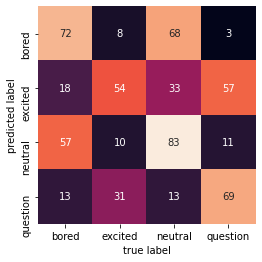

In [285]:
'''sns.heatmap(x,square=True, annot=True, fmt='d', cbar=False,
            xticklabels = tones,
            yticklabels = tones)
plt.xlabel('true label')
plt.ylabel('predicted label')'''

In [286]:
#print(classification_report(y_val, yv_p))

              precision    recall  f1-score   support

       bored       0.45      0.48      0.46       151
     excited       0.52      0.33      0.41       162
     neutral       0.42      0.52      0.46       161
    question       0.49      0.55      0.52       126

    accuracy                           0.46       600
   macro avg       0.47      0.47      0.46       600
weighted avg       0.47      0.46      0.46       600



In [287]:
#print(classification_report(y_train, yt_p))

              precision    recall  f1-score   support

       bored       0.52      0.55      0.53       359
     excited       0.55      0.38      0.45       320
     neutral       0.46      0.55      0.50       379
    question       0.59      0.61      0.60       342

    accuracy                           0.52      1400
   macro avg       0.53      0.52      0.52      1400
weighted avg       0.53      0.52      0.52      1400



**Naive Bayes using Standard Scaler**

In [288]:
gnb = GaussianNB()

In [289]:
gnb.fit(X_train,y_train)

yt_p = gnb.predict(X_train)
yv_p = gnb.predict(X_val)

print('Training Accuracy', np.mean(yt_p==y_train))
print('Validation  Accuracy', np.mean(yv_p==y_val))

Training Accuracy 0.4707142857142857
Validation  Accuracy 0.43166666666666664


In [290]:
x = metrics.confusion_matrix(y_val, yv_p, labels=['bored', 'excited', 'neutral', 'question'])
y = metrics.confusion_matrix(y_train, yt_p, labels=['bored', 'excited', 'neutral', 'question'])
tones = ['bored', 'excited', 'neutral', 'question']

Text(91.68, 0.5, 'predicted label')

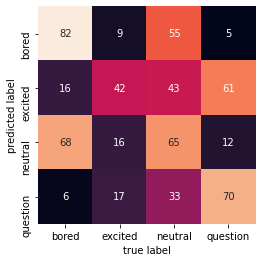

In [291]:
sns.heatmap(x,square=True, annot=True, fmt='d', cbar=False,
            xticklabels = tones,
            yticklabels = tones)
plt.xlabel('true label')
plt.ylabel('predicted label')

In [292]:
print(classification_report(y_val, yv_p))

              precision    recall  f1-score   support

       bored       0.48      0.54      0.51       151
     excited       0.50      0.26      0.34       162
     neutral       0.33      0.40      0.36       161
    question       0.47      0.56      0.51       126

    accuracy                           0.43       600
   macro avg       0.45      0.44      0.43       600
weighted avg       0.44      0.43      0.42       600



In [293]:
print(classification_report(y_train, yt_p))

              precision    recall  f1-score   support

       bored       0.52      0.58      0.55       359
     excited       0.48      0.28      0.36       320
     neutral       0.37      0.46      0.41       379
    question       0.54      0.54      0.54       342

    accuracy                           0.47      1400
   macro avg       0.48      0.47      0.46      1400
weighted avg       0.48      0.47      0.47      1400



Logistic Regression using Standard Scaler

In [294]:
parameters= {
    'penalty': ['l1', 'elasticnet', 'none'],
    'C': [0.1,2,3,4,5],
    'class_weight': ['dict', 'balanced'],
    'solver': ['newton_cg', 'liblinear', 'sag', 'saga'],
    'multi_class': ['multinomial'],

}

In [295]:
lgr = LogisticRegression()

In [296]:
grid_lgr = GridSearchCV(lgr, parameters, n_jobs=-1)
grid_lgr.fit(X_train,y_train)
yt_p = grid_lgr.predict(X_train)
yv_p = grid_lgr.predict(X_val)

print('Training Accuracy', np.mean(yt_p==y_train))
print('Validation  Accuracy', np.mean(yv_p==y_val))

Training Accuracy 0.4685714285714286
Validation  Accuracy 0.45166666666666666


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1505: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


In [297]:
grid_lgr.best_score_

0.4621428571428572

In [298]:
grid_lgr.best_params_

{'C': 0.1,
 'class_weight': 'balanced',
 'multi_class': 'multinomial',
 'penalty': 'none',
 'solver': 'sag'}

In [299]:
lgr = LogisticRegression(C=2, class_weight='balanced', multi_class='multinomial',  solver='saga')
lgr.fit(X_train,y_train)
yt_p = lgr.predict(X_train)
yv_p = lgr.predict(X_val) 

print('Training Accuracy', np.mean(yt_p==y_train))
print('Validation  Accuracy', np.mean(yv_p==y_val))

Training Accuracy 0.4614285714285714
Validation  Accuracy 0.455


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


In [300]:
x = metrics.confusion_matrix(y_val, yv_p, labels=['bored', 'excited', 'neutral', 'question'])
y = metrics.confusion_matrix(y_train, yt_p, labels=['bored', 'excited', 'neutral', 'question'])
tones = ['bored', 'excited', 'neutral', 'question']

Text(91.68, 0.5, 'predicted label')

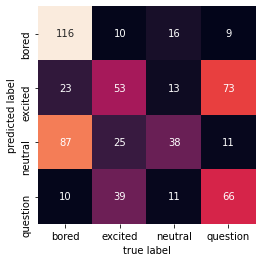

In [301]:
sns.heatmap(x,square=True, annot=True, fmt='d', cbar=False,
            xticklabels = tones,
            yticklabels = tones)
plt.xlabel('true label')
plt.ylabel('predicted label')

In [302]:
print(classification_report(y_val, yv_p))

              precision    recall  f1-score   support

       bored       0.49      0.77      0.60       151
     excited       0.42      0.33      0.37       162
     neutral       0.49      0.24      0.32       161
    question       0.42      0.52      0.46       126

    accuracy                           0.46       600
   macro avg       0.45      0.46      0.44       600
weighted avg       0.45      0.46      0.43       600



In [303]:
print(classification_report(y_train, yt_p))

              precision    recall  f1-score   support

       bored       0.49      0.73      0.59       359
     excited       0.37      0.31      0.34       320
     neutral       0.47      0.27      0.35       379
    question       0.47      0.53      0.50       342

    accuracy                           0.46      1400
   macro avg       0.45      0.46      0.44      1400
weighted avg       0.45      0.46      0.44      1400



**MultiLayer Perceptron**

In [304]:
'''parameters = {
    'activation': ['logistic', 'tanh'],
    'solver': ['lbfgs', 'sgd'],
    'max_iter': [300,400,500],
    'random_state': [1,2,3]
    
}'''

In [324]:
#clf_grid = MLPClassifier()

In [325]:
#grid_mlp = GridSearchCV(clf_grid, parameters, n_jobs=-1)
#grid_mlp.fit(X_train_normalised,y_train)


GridSearchCV(cv=None, error_score=nan,
             estimator=MLPClassifier(activation='relu', alpha=0.0001,
                                     batch_size='auto', beta_1=0.9,
                                     beta_2=0.999, early_stopping=False,
                                     epsilon=1e-08, hidden_layer_sizes=(100,),
                                     learning_rate='constant',
                                     learning_rate_init=0.001, max_fun=15000,
                                     max_iter=200, momentum=0.9,
                                     n_iter_no_change=10,
                                     nesterovs_momentum=True, power_t=0.5,
                                     random_state=None, shuffle=True,
                                     solver='adam', tol=0.0001,
                                     validation_fraction=0.1, verbose=False,
                                     warm_start=False),
             iid='deprecated', n_jobs=-1,
             param_grid

In [326]:
#grid_mlp.best_score_

0.49642857142857144

In [327]:
#grid_mlp.best_params_

{'activation': 'logistic',
 'max_iter': 300,
 'random_state': 1,
 'solver': 'lbfgs'}

In [328]:
'''clf = MLPClassifier(max_iter=300, solver='lbfgs', activation='logistic',random_state=1).fit(X_train_normalised, y_train)
yt_p = clf.predict(X_train_normalised)
yv_p = clf.predict(X_val_normalised)
'''


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


In [329]:
#print('Training Accuracy', np.mean(yt_p==y_train))
#print('Validation  Accuracy', np.mean(yv_p==y_val))

Training Accuracy 0.6521428571428571
Validation  Accuracy 0.5066666666666667


In [330]:
#x = metrics.confusion_matrix(y_val, yv_p, labels=['bored', 'excited', 'neutral', 'question'])
#y = metrics.confusion_matrix(y_train, yt_p, labels=['bored', 'excited', 'neutral', 'question'])
#tones = ['bored', 'excited', 'neutral', 'question']

Text(91.68, 0.5, 'predicted label')

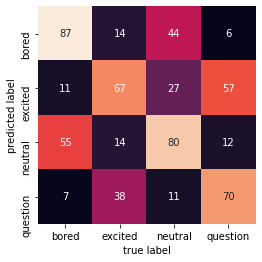

In [331]:
'''sns.heatmap(x,square=True, annot=True, fmt='d', cbar=False,
            xticklabels = tones,
            yticklabels = tones)
plt.xlabel('true label')
plt.ylabel('predicted label')'''

In [332]:
#print(classification_report(y_val, yv_p))

              precision    recall  f1-score   support

       bored       0.54      0.58      0.56       151
     excited       0.50      0.41      0.45       162
     neutral       0.49      0.50      0.50       161
    question       0.48      0.56      0.52       126

    accuracy                           0.51       600
   macro avg       0.51      0.51      0.51       600
weighted avg       0.51      0.51      0.50       600



In [333]:
#print(classification_report(y_train, yt_p))

              precision    recall  f1-score   support

       bored       0.70      0.68      0.69       359
     excited       0.62      0.58      0.60       320
     neutral       0.63      0.65      0.64       379
    question       0.65      0.69      0.67       342

    accuracy                           0.65      1400
   macro avg       0.65      0.65      0.65      1400
weighted avg       0.65      0.65      0.65      1400



**Multilayer perceptron on standardscaler**

In [313]:
parameters = {
    'activation': ['logistic', 'tanh'],
    'solver': ['lbfgs', 'sgd'],
    'max_iter': [300,400,500],
    'random_state': [1,2,3]
    
}

In [314]:
clf_grid = MLPClassifier()

In [315]:
grid_mlp = GridSearchCV(clf_grid, parameters, n_jobs=-1)
grid_mlp.fit(X_train,y_train)


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


GridSearchCV(cv=None, error_score=nan,
             estimator=MLPClassifier(activation='relu', alpha=0.0001,
                                     batch_size='auto', beta_1=0.9,
                                     beta_2=0.999, early_stopping=False,
                                     epsilon=1e-08, hidden_layer_sizes=(100,),
                                     learning_rate='constant',
                                     learning_rate_init=0.001, max_fun=15000,
                                     max_iter=200, momentum=0.9,
                                     n_iter_no_change=10,
                                     nesterovs_momentum=True, power_t=0.5,
                                     random_state=None, shuffle=True,
                                     solver='adam', tol=0.0001,
                                     validation_fraction=0.1, verbose=False,
                                     warm_start=False),
             iid='deprecated', n_jobs=-1,
             param_grid

In [316]:
grid_mlp.best_score_

0.5014285714285714

In [317]:
grid_mlp.best_params_

{'activation': 'tanh', 'max_iter': 500, 'random_state': 1, 'solver': 'lbfgs'}

In [318]:
clf = MLPClassifier(max_iter=500, solver='lbfgs', activation='tanh',random_state=1).fit(X_train, y_train)
yt_p = clf.predict(X_train)
yv_p = clf.predict(X_val)



/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


In [319]:
print('Training Accuracy', np.mean(yt_p==y_train))
print('Validation  Accuracy', np.mean(yv_p==y_val))

Training Accuracy 0.5128571428571429
Validation  Accuracy 0.48333333333333334


Here we are getting around 48% accuracy in valdiation Accuracy and around 51% on training accuracy.

In [320]:
x = metrics.confusion_matrix(y_val, yv_p, labels=['bored', 'excited', 'neutral', 'question'])
y = metrics.confusion_matrix(y_train, yt_p, labels=['bored', 'excited', 'neutral', 'question'])
tones = ['bored', 'excited', 'neutral', 'question']

Text(91.68, 0.5, 'predicted label')

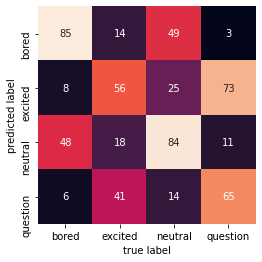

In [321]:
sns.heatmap(x,square=True, annot=True, fmt='d', cbar=False,
            xticklabels = tones,
            yticklabels = tones)
plt.xlabel('true label')
plt.ylabel('predicted label')

In [322]:
print(classification_report(y_val, yv_p))

              precision    recall  f1-score   support

       bored       0.58      0.56      0.57       151
     excited       0.43      0.35      0.38       162
     neutral       0.49      0.52      0.50       161
    question       0.43      0.52      0.47       126

    accuracy                           0.48       600
   macro avg       0.48      0.49      0.48       600
weighted avg       0.48      0.48      0.48       600



In [323]:
print(classification_report(y_train, yt_p))

              precision    recall  f1-score   support

       bored       0.61      0.55      0.58       359
     excited       0.41      0.41      0.41       320
     neutral       0.49      0.54      0.52       379
    question       0.55      0.54      0.54       342

    accuracy                           0.51      1400
   macro avg       0.51      0.51      0.51      1400
weighted avg       0.52      0.51      0.51      1400



**Sumaary**

I build 6 models which are 

1) SVM

2) RandomForest

3) KNN

4) Naive Bayes

5) Logistic Regression

6) MuliLayer Perceptron Classifier

I build these models and trained them on hyperparameters tuning them with the help of GridSearch CV, I build the model for both normalised predictors and without normalised also and with extra features such as mfcc and experimented them.

Finally, Getting the highest Accuracy on the SVM model with the accuracy of 53.5% on the validation data with normalised predictors.